In [1]:
from dependencies import *

In [ ]:
ds1=xr.open_dataset("data/processed/Bicubic/Train/targets_tas_masked_train.nc")
ds2=xr.open_dataset("data/processed/Bicubic/Train/targets_precip_masked_train.nc")
TabsD = ds1['TabsD']
RhiresD= ds2["RhiresD"]

In [3]:
lon = TabsD.lon
lat = TabsD.lat
mask = np.isnan(lon) | np.isnan(lat)
TabsD_gridded = TabsD.where(~mask)
RhiresD_gridded = RhiresD.where(~mask)

#Assuming TabsD is normally distributed for every grid cell in the summer , using MLE to estimate mean and variance 

In [4]:
#Mean
mu_tabs= np.mean (TabsD_gridded, axis=0) 
sigma_tabs= np.std(TabsD_gridded, axis=0, ddof=0) #Degrees of freedom =0 to have the MLE estimator

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Plot for MLE parameters for temperature 

In [5]:
E = ds1["E"].values  
N = ds1["N"].values  
E_grid, N_grid = np.meshgrid(E, N)

transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(E_grid, N_grid)

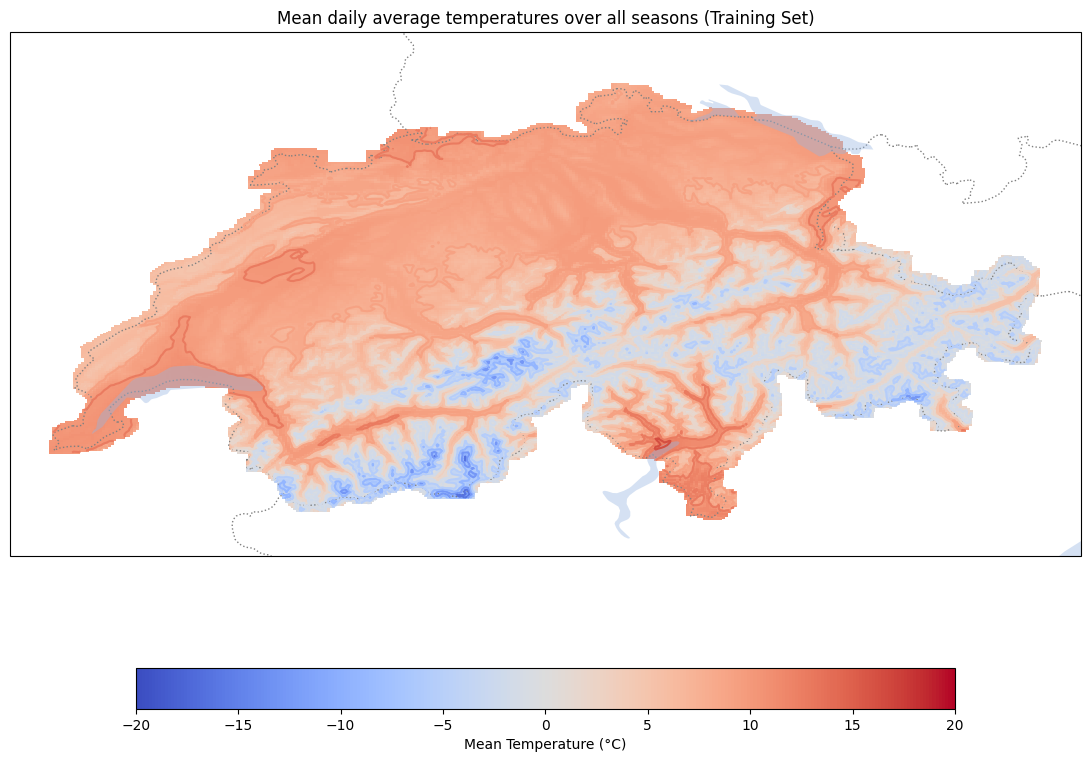

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

plot = ax.pcolormesh(lon, lat, mu_tabs, cmap="coolwarm", shading="auto", vmin=-20,vmax=20, transform=ccrs.PlateCarree())
contours = ax.contour(lon, lat, mu_tabs, 10, cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(plot, ax=ax, shrink=0.7,orientation='horizontal')
cbar.set_label("Mean Temperature (°C)")
plt.title("Mean daily average temperatures over all seasons (Training Set)")
plt.tight_layout()
plt.show()

Choosing the nearest grid cell near Locarno , Switzerland for the rest of the analysis

In [7]:
locarno_lat= 46.1709
locarno_lon=  8.7995

dist= np.sqrt((lat-locarno_lat)**2 + (lon-locarno_lon)**2)
min_dist_index= np.unravel_index(np.argmin(dist),dist.shape)
closest_lon= lon [min_dist_index]
closest_lat= lat [min_dist_index]

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amoun

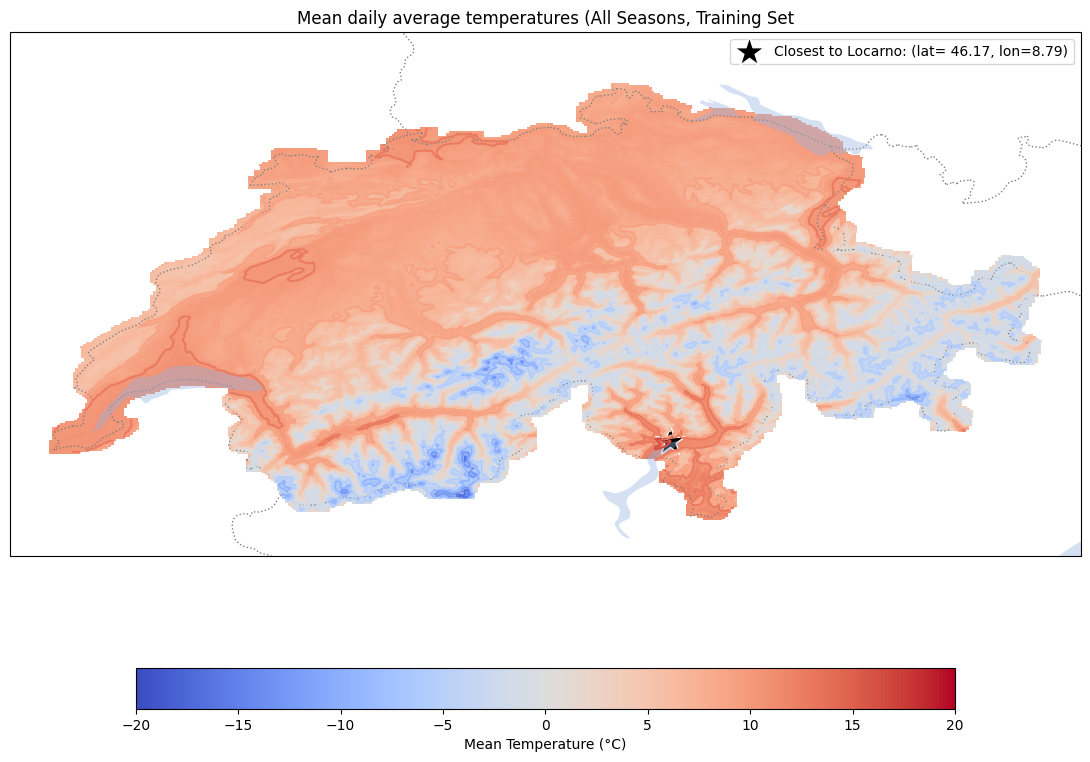

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

plot = ax.pcolormesh(lon, lat, mu_tabs, cmap="coolwarm", shading="auto", vmin=-20,vmax=20, transform=ccrs.PlateCarree())
contours = ax.contour(lon, lat, mu_tabs, 10, cmap='coolwarm', transform=ccrs.PlateCarree())

cbar = plt.colorbar(plot, ax=ax, shrink=0.7, orientation='horizontal')
cbar.set_label("Mean Temperature (°C)")
plt.title("Mean daily average temperatures (All Seasons, Training Set")

ax.scatter(closest_lon, closest_lat, color='black', s=500, edgecolors='white', marker='*', label='Closest to Locarno: (lat= 46.17, lon=8.79)')

ax.legend()
plt.tight_layout()
plt.show()

In [9]:
closest_lat,closest_lon

(np.float64(46.173708901049054), np.float64(8.804796481751007))

In [10]:
lat_idx = np.abs(TabsD.coords['N'] - closest_lat).argmin()
lon_idx = np.abs(TabsD.coords['E'] - closest_lon).argmin()
tabsd = TabsD.isel(N=lat_idx, E=lon_idx)
rhiresd = RhiresD.isel(N=lat_idx, E=lon_idx)

REST OF THE ANALYSIS : only for grid cell closest_lat,closest_lon saved in tabsd and rhiresd variables respectively. 

Estimation of the mean and standard deviation 

SEPARATING RAINY DAYS FROM NON RAINY: rainy day analysis here

In [11]:
closest_lat_idx, closest_lon_idx = min_dist_index
tabsd = TabsD_gridded[:, closest_lat_idx, closest_lon_idx]
rhiresd = RhiresD_gridded[:, closest_lat_idx, closest_lon_idx]

MEAN AND VARIANCE

CHOOSING ONLY WET DAYS 

In [12]:
tabsd_wet= tabsd[rhiresd>=0.1]
rhiresd_wet=rhiresd[rhiresd>=0.1]

print(tabsd_wet)

<xarray.DataArray 'TabsD' (time: 5154)> Size: 21kB
array([22.142902 , 12.51375  , 22.755457 , ...,  1.6229733,  5.28465  ,
        7.730516 ], shape=(5154,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 41kB 1978-07-14 1977-05-02 ... 2021-02-04
    lon      float32 4B 8.805
    lat      float32 4B 46.17
    E        float64 8B 2.706e+06
    N        float64 8B 1.114e+06
Attributes:
    version:         v1.2
    long_name:       daily mean temperature
    esri_pe_string:  PROJCS["CH1903+_LV95",GEOGCS["GCS_CH1903+",DATUM["D_CH19...
    prod_date:       2023-11-16 10:20:12
    units:           degree
    grid_mapping:    swiss_lv95_coordinates
    grid_name:       ch01r.swiss.lv95


In [13]:
print(rhiresd_wet)

<xarray.DataArray 'RhiresD' (time: 5154)> Size: 21kB
array([ 0.6301522 , 13.831486  ,  3.8564672 , ..., 14.976419  ,
        0.44287407,  1.0933168 ], shape=(5154,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 41kB 1978-07-14 1977-05-02 ... 2021-02-04
    lon      float32 4B 8.805
    lat      float32 4B 46.17
    E        float64 8B 2.706e+06
    N        float64 8B 1.114e+06
Attributes:
    version:         v2.0
    long_name:       daily precipitation sum
    esri_pe_string:  PROJCS["CH1903+_LV95",GEOGCS["GCS_CH1903+",DATUM["D_CH19...
    prod_date:       2023-11-17 12:23:54
    units:           millimeter
    grid_mapping:    swiss_lv95_coordinates
    grid_name:       ch01h.swiss.lv95


In [14]:
mu_tabs_cell= np.mean (tabsd_wet)
sigma_tabs_cell = np.std(tabsd,ddof=0) #ddof=0 for MLE where variance is divided by n

In [15]:
mu_tabs_cell

<xarray.DataArray 'TabsD' ()> Size: 4B
array(12.955475, dtype=float32)
Coordinates:
    lon      float32 4B 8.805
    lat      float32 4B 46.17
    E        float64 8B 2.706e+06
    N        float64 8B 1.114e+06

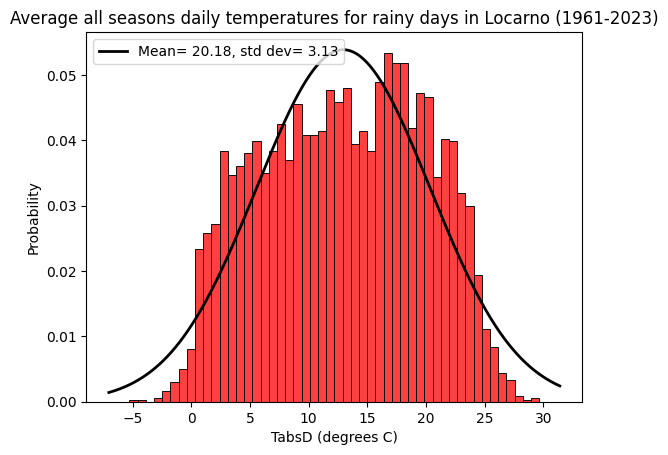

In [16]:
sns.histplot(tabsd_wet, kde=False, color="red", stat="density", bins =50)

xmin, xmax = plt.xlim() 
x= np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu_tabs_cell, sigma_tabs_cell)
plt.plot(x, p, 'k', linewidth=2)

plt.title("Average all seasons daily temperatures for rainy days in Locarno (1961-2023)")
plt.xlabel("TabsD (degrees C)")
plt.ylabel("Probability")
plt.legend([f"Mean= 20.18, std dev= 3.13"],loc="upper left")
plt.show()

QQ plot between the empirical distribition and MLE fitted normal distribution

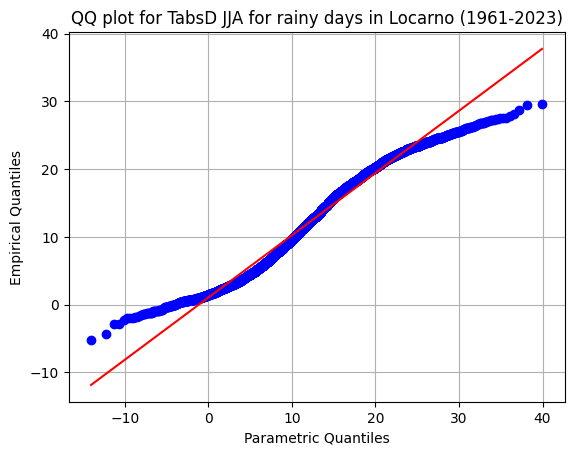

In [17]:
stats.probplot(tabsd_wet, dist="norm" , sparams=(mu_tabs_cell, sigma_tabs_cell), plot=plt)
plt.title("QQ plot for TabsD JJA for rainy days in Locarno (1961-2023)")

plt.xlabel("Parametric Quantiles")
plt.ylabel("Empirical Quantiles")

plt.grid(True)
plt.show()

CDF

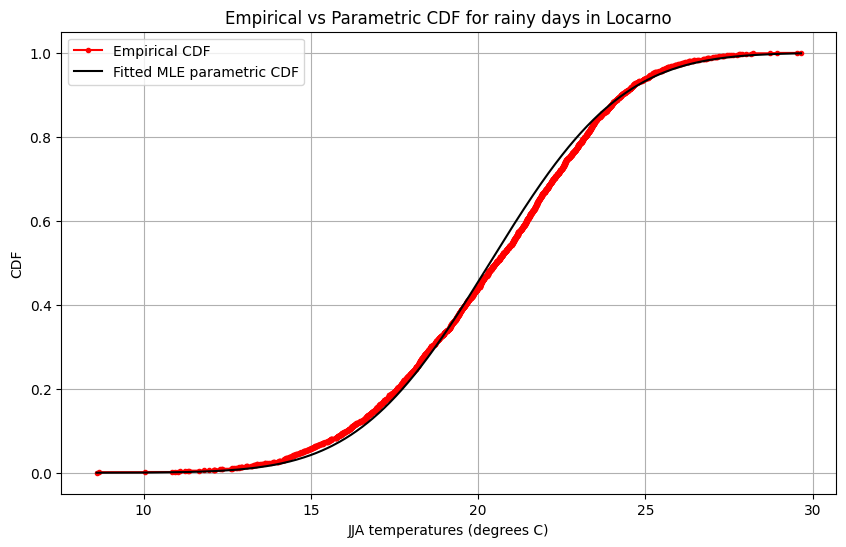

In [18]:
sorted_data= np.sort (tabsd_wet)
fitted_CDF = stats.norm.cdf (sorted_data, loc= mu_tabs_cell, scale= sigma_tabs_cell)

empirical_CDF= np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(10,6))

plt.step(sorted_data, empirical_CDF, color="red", marker=".",label="Empirical CDF")

plt.plot(sorted_data, fitted_CDF, color="black", label="Fitted MLE parametric CDF")
plt.xlabel("JJA temperatures (degrees C)")
plt.ylabel("CDF")
plt.title("Empirical vs Parametric CDF for rainy days in Locarno")

plt.grid(True)
plt.legend()
plt.show()

KS test for TabsD for Locarno 

In [18]:
ks_stat_tabsd, p_value_tabsd = stats.kstest(tabsd_wet, "norm", args=(mu_tabs_cell, sigma_tabs_cell))

print(f"KS statistic is {ks_stat_tabsd:.5f} with a p value of {p_value_tabsd:.5f} ")

KS statistic is 0.04242 with a p value of 0.00000 


Reference: "The Kolmogorov-Smirnov test is more likely to reject the null hypothesis for large datasets, as even small differences between the empirical distribution and the theoretical distribution can become statistically significant as the sample size grows." — Siegel, A.F., and Castellan, N.J., Nonparametric Statistics for the Behavioral Sciences.

###################################PRECIPITATION#######################

#PDF of only wet days (RhiresD_pooled>1) (dont have to worry about probability of rain anymore, whats 0 in coarse remains zero in SR because of lack of explicit bias correction of values$)

MAYBE THE CULTPRIUT WAS THE FUCKING THRESHOLD+++, keep it more than 1

Maximum likelihood Estimation

In [19]:
def NLL(params, data):
    alpha, beta = params
    if alpha<=0 or beta<=0:
        return np.inf
    return -np.sum(np.log(gamma.pdf(data, alpha, beta)))

Mean = alpha*beta , Variance = alpha*beta**2

Initial guesses : Mean squared/ Variance for alpha

beta= Variance/ Mean

In [20]:
mean_rhiresd= np.mean (rhiresd_wet)

variance_rhiresd= np.var(rhiresd_wet)

In [21]:
alpha_0= mean_rhiresd**2/variance_rhiresd

beta_0= variance_rhiresd/mean_rhiresd

guess_0= [alpha_0,beta_0]

In [22]:
result= minimize(NLL, guess_0, args=(rhiresd_wet,))
alpha_mle, beta_mle= result.x

/tmp/ipykernel_2924065/569718765.py:5: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(gamma.pdf(data, alpha, beta)))
/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [23]:
tabsd_wet = np.ravel(tabsd_wet)

rhiresd_wet = np.ravel(rhiresd_wet)

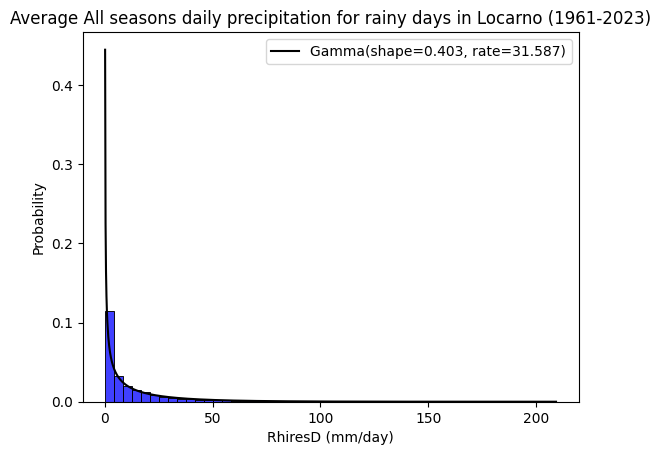

In [25]:

sns.histplot(rhiresd_wet, kde=False, color="blue", stat="density", bins=50)
x = np.linspace(min(rhiresd_wet), max(rhiresd_wet), 1000)

pdf_gamma = gamma.pdf(x, a=alpha_mle, scale=beta_mle)

plt.plot(x, pdf_gamma, 'k-', label=f"Gamma(shape={alpha_mle:.3f}, rate={beta_mle:.3f})")

plt.title("Average All seasons daily precipitation for rainy days in Locarno (1961-2023)")
plt.xlabel("RhiresD (mm/day)")
plt.ylabel("Probability")
plt.legend()
plt.show()

Scatter plot along with marginal histograms 

/tmp/ipykernel_2924065/2774232427.py:25: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


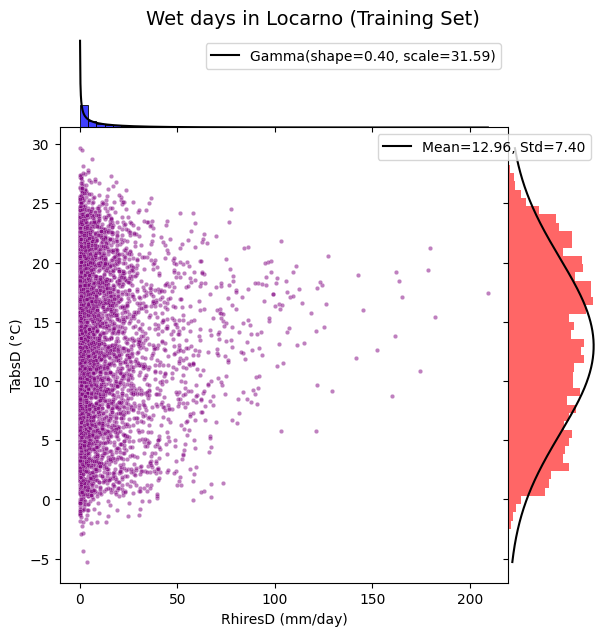

In [26]:
#Scatterplot
g = sns.JointGrid(x=rhiresd_wet, y=tabsd_wet, space=0, height=6)
g.plot_joint(sns.scatterplot, color="purple", s=10, alpha=0.5)

#Marginal histogram for precipitation
sns.histplot(rhiresd_wet, bins=50, stat='density', color='blue', ax=g.ax_marg_x, kde=False)
x_rain = np.linspace(min(rhiresd_wet), max(rhiresd_wet), 1000)
pdf_rain = gamma.pdf(x_rain, a=alpha_mle, scale=beta_mle)
g.ax_marg_x.plot(x_rain, pdf_rain, 'k-', label=f"Gamma(shape={alpha_mle:.2f}, scale={beta_mle:.2f})")
g.ax_marg_x.legend(loc="upper right")
counts, bins = np.histogram(tabsd_wet, bins=50, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
g.ax_marg_y.barh(bin_centers, counts, height=np.diff(bins), color='red', alpha=0.6)

#Marginal histogram for temperature
x_temp = np.linspace(min(tabsd_wet), max(tabsd_wet), 1000)
pdf_temp = norm.pdf(x_temp, mu_tabs_cell, sigma_tabs_cell)
g.ax_marg_y.plot(pdf_temp, x_temp, 'k-', label=f"Mean={mu_tabs_cell:.2f}, Std={sigma_tabs_cell:.2f}")
g.ax_marg_y.legend(loc="upper right")

g.ax_joint.set_xlabel("RhiresD (mm/day)")
g.ax_joint.set_ylabel("TabsD (°C)")
g.fig.suptitle("Wet days in Locarno (Training Set)", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


MLE for RhiresD for only rainy days: for estimating alpha and beta assuming the underlying gamma distribution

In [27]:
sorted_data_precip= np.sort(rhiresd_wet)
fitted_CDF_precip_gamma= gamma.cdf(sorted_data_precip, alpha_mle, scale= beta_mle)

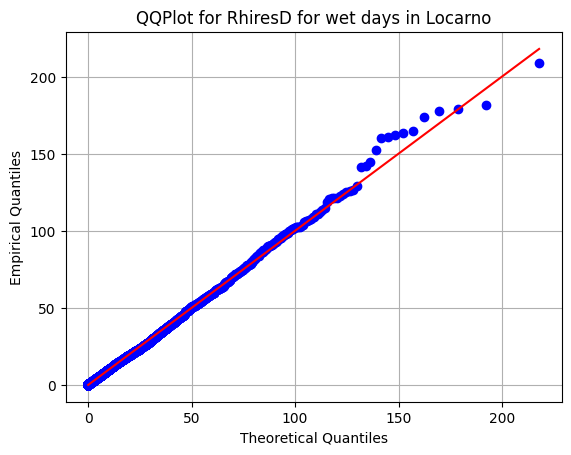

In [28]:
stats.probplot(rhiresd_wet, dist="gamma", sparams=(alpha_mle,0,beta_mle), plot=plt)
plt.title("QQPlot for RhiresD for wet days in Locarno")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Empirical Quantiles")
plt.grid(True)
plt.show()

In [29]:
alpha_mle, beta_mle

(np.float32(0.4033387), np.float32(31.587496))

In [30]:
sorted_data_precip= np.sort(rhiresd_wet)
fitted_CDF_precip_gamma= gamma.cdf(sorted_data_precip, alpha_mle, scale= beta_mle)

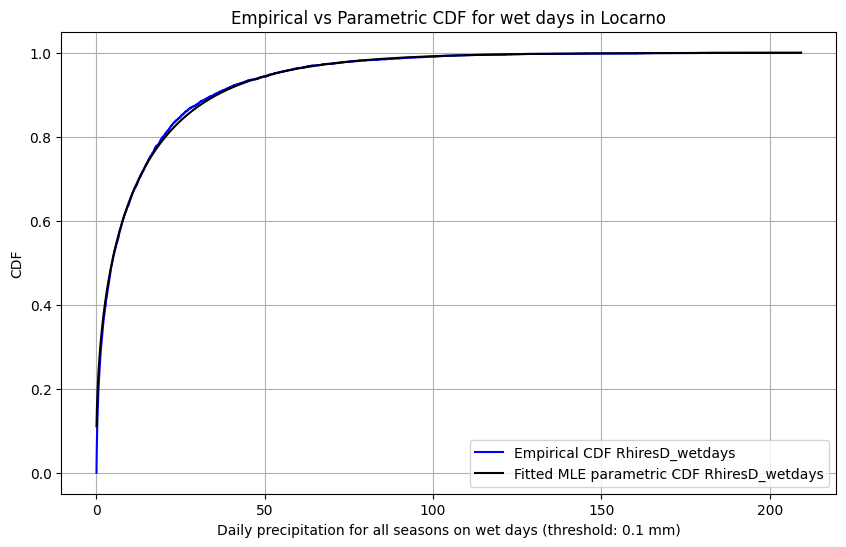

In [31]:
empirical_CDF_precip= np.arange(1,len(sorted_data_precip)+1)/ len(sorted_data_precip)

plt.figure(figsize=(10,6))

plt.step(sorted_data_precip, empirical_CDF_precip, color="blue", where='post',label="Empirical CDF RhiresD_wetdays")

plt.plot(sorted_data_precip, fitted_CDF_precip_gamma, color="black", label="Fitted MLE parametric CDF RhiresD_wetdays")
plt.xlabel("Daily precipitation for all seasons on wet days (threshold: 0.1 mm)")
plt.ylabel("CDF")
plt.title("Empirical vs Parametric CDF for wet days in Locarno")

plt.grid(True)
plt.legend()
plt.show()

B: KS Test for RhiresD_wet_days considering it is assumed that wet days follow a Gamma distribution

In [32]:
ks_stat_wetdays, p_value_wetdays = stats.kstest(rhiresd_wet, "gamma", args=(alpha_mle, beta_mle))

print(f"KS statistic for wet days for daily precip in Locarno is {ks_stat_wetdays:.3f} with a p value of {p_value_wetdays:.3f} ")

KS statistic for wet days for daily precip in Locarno is 0.886 with a p value of 0.000 


                          ##########GAUSSIAN COPULA###################

The Gaussian copula uses Pearson for dependence structure

In [33]:
#Calculating empirical CDF for TabsD and RhiresD
ecdf_tabsd= ECDF(tabsd_wet)
ecdf_rhiresd= ECDF(rhiresd_wet)

In [36]:
tabsd_wet.shape

(5154,)

In [34]:
#Performing PIT
tabs_U_empirical= ecdf_tabsd(tabsd_wet)
rhires_U_empirical= ecdf_rhiresd(rhiresd_wet)

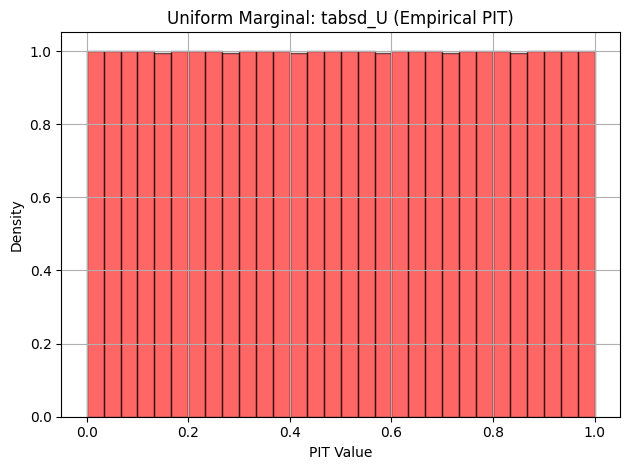

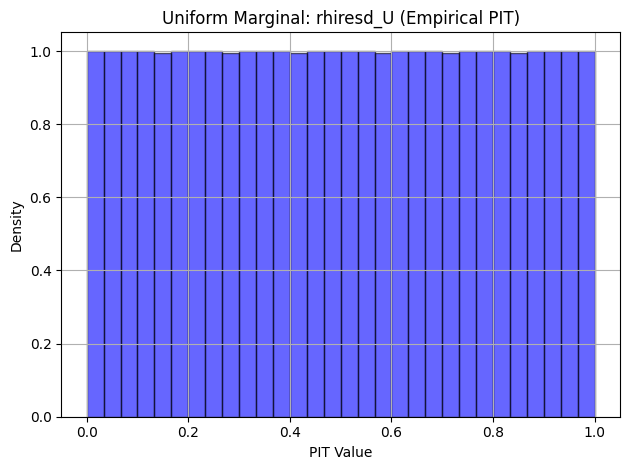

In [35]:
# marginal histogram  tabs_U_empirical
plt.figure()
plt.hist(tabs_U_empirical, bins=30, density=True, alpha=0.6, color='red', edgecolor='k')
plt.title('Uniform Marginal: tabsd_U (Empirical PIT)')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

# marginal histogram rhires_U_empirical
plt.figure()
plt.hist(rhires_U_empirical, bins=30, density=True, alpha=0.6, color='blue', edgecolor='k')
plt.title('Uniform Marginal: rhiresd_U (Empirical PIT)')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

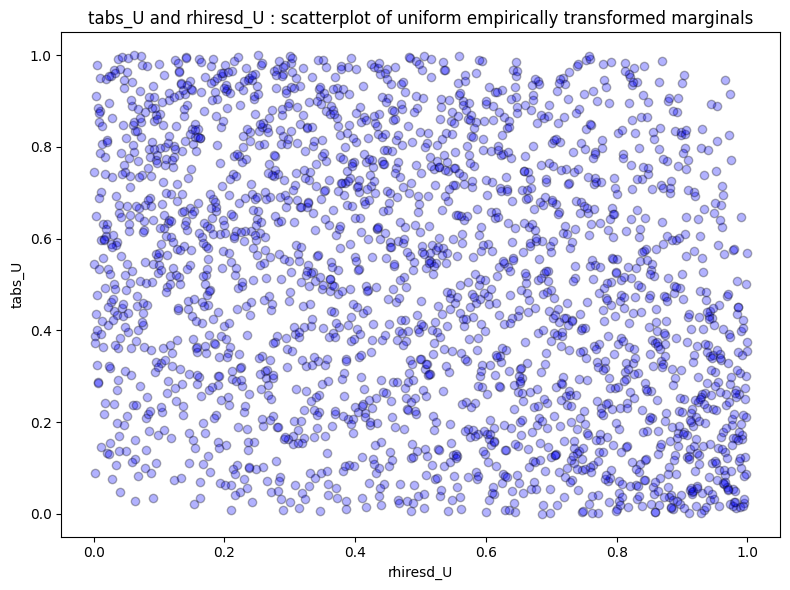

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(rhires_U_empirical,tabs_U_empirical, alpha=0.3, color='b', edgecolor='k')

plt.title('tabs_U and rhiresd_U : scatterplot of uniform empirically transformed marginals')
plt.ylabel('tabs_U')
plt.xlabel('rhiresd_U')

plt.grid(False)
plt.tight_layout()
plt.show()

In [37]:
epsilon = 1e-6
tabs_U_clipped = np.clip(tabs_U_empirical, epsilon, 1 - epsilon)
rhires_U_clipped = np.clip(rhires_U_empirical, epsilon, 1 - epsilon)

tabs_Z = norm.ppf(tabs_U_clipped)
rhires_Z = norm.ppf(rhires_U_clipped)

In [38]:
Z_values_stacked= np.column_stack((tabs_Z, rhires_Z))

#Copula correlation matrix : Pearson for gaussian copula
copula_corr_matrix = np.corrcoef(Z_values_stacked, rowvar=False)
print(copula_corr_matrix)

[[ 1.         -0.02790695]
 [-0.02790695  1.        ]]


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvironment/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


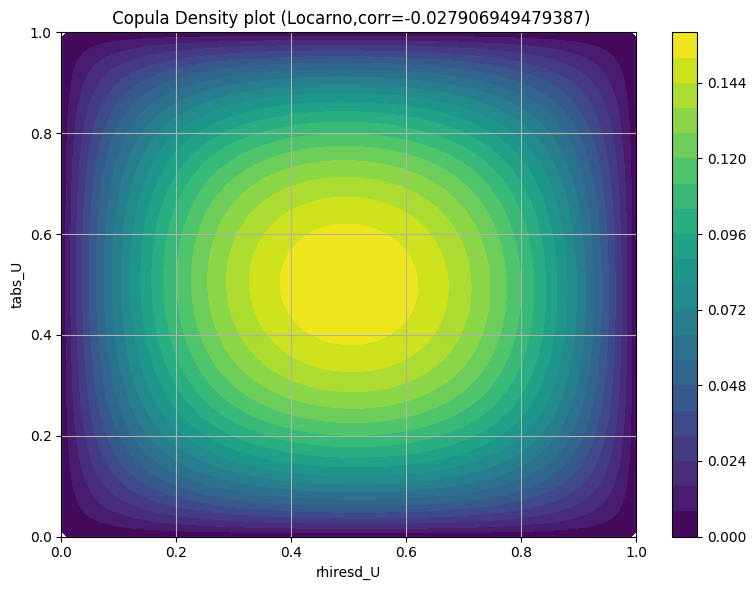

In [39]:
u = np.linspace(0, 1, 100) #Random number generation between 0 and 1 for the copula
U1, U2 = np.meshgrid(u, u)
points = np.stack([U1.ravel(), U2.ravel()], axis=1)

Z = norm.ppf(points)

rv = multivariate_normal(mean=[0, 0], cov=copula_corr_matrix)
pdf = rv.pdf(Z).reshape(U1.shape)


plt.figure(figsize=(8, 6))
cp = plt.contourf(U1, U2, pdf, levels=20, cmap='viridis')
plt.colorbar(cp)
plt.title(f' Copula Density plot (Locarno,corr={copula_corr_matrix[0][1]})')
plt.xlabel('rhiresd_U')
plt.ylabel('tabs_U')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
n_samples=5154

simulated_pseudo= np.random.multivariate_normal(mean=[0,0], cov=copula_corr_matrix, size=n_samples)
simulated_U = norm.cdf(simulated_pseudo) #normal cdf to get simulated marginals
rhires_U_sim= simulated_U[:,0] # simulated precip on the x axis
tabs_U_sim= simulated_U[:,1] # simulated tabsd uniform marginals on the y axis

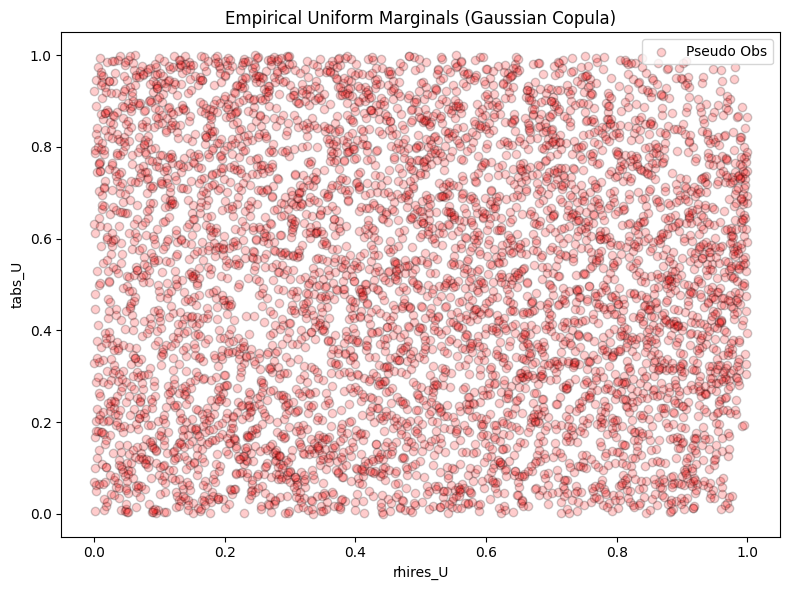

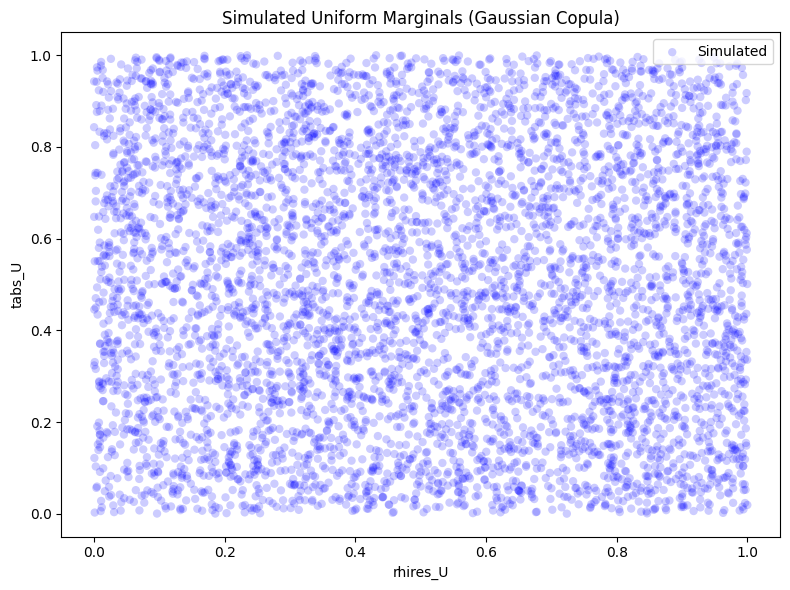

In [44]:
# First plot: Pseudo Observations (Empirical)
plt.figure(figsize=(8, 6))
plt.scatter(rhires_U_empirical, tabs_U_empirical, alpha=0.2, color='r', edgecolor='k', label='Pseudo Obs')
plt.title('Empirical Uniform Marginals (Gaussian Copula)')
plt.xlabel('rhires_U')
plt.ylabel('tabs_U')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Second plot: Simulated Observations
plt.figure(figsize=(8, 6))
plt.scatter(rhires_U_sim, tabs_U_sim, alpha=0.2, color='blue', edgecolor='none', label='Simulated')
plt.title('Simulated Uniform Marginals (Gaussian Copula)')
plt.xlabel('rhires_U')
plt.ylabel('tabs_U')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()
